# Simple Humpback Whale CNN

In this notebook we will be collecting, cleaning, and preprocessing data related to some humpback whale flukes in order to build and train a model to classify the whales!

\#TODO: Data cleaning, data augmentation, transitioning model to an image generator with class weights.

\#TODO ADVANCED: Adding a bounding box CNN structure for greater accuracy. Potentially adding/converting to a Siamese Network.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image, clear_output
import random
import tensorflow as tf

In [2]:
root_path = 'data/'
train_path = root_path + 'train/'
test_path = root_path + 'test/'

In [3]:
training_data = pd.read_csv(root_path + 'train.csv')   

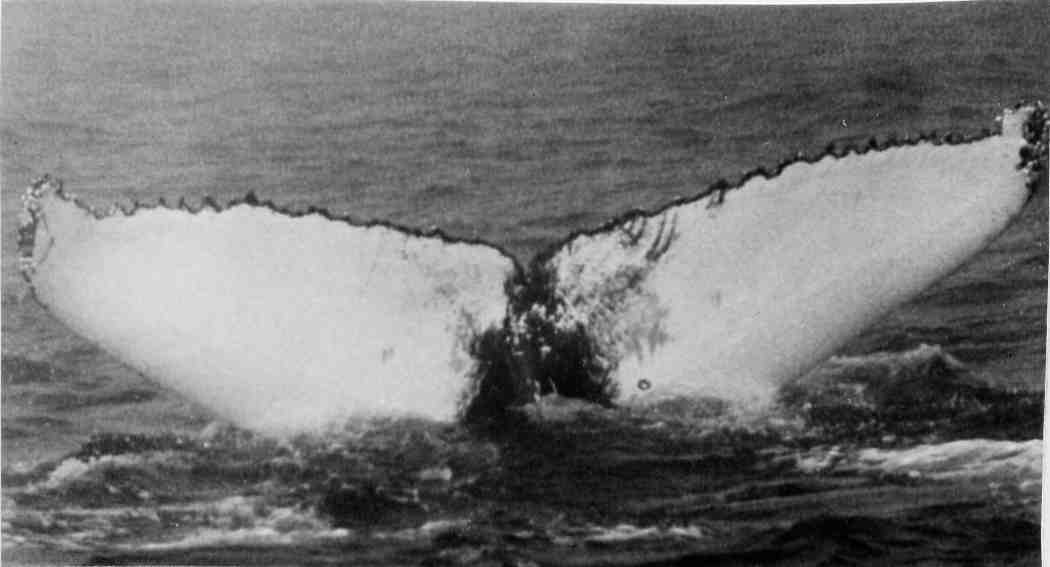

In [4]:
random_image = train_path + random.choice(training_data['Image'])
Image(random_image)

## Data Processing:

Create helper functions to modify the training data to a usable format for training. Reshape/convert to an array and normalize the values between 0 and 1.

Create a helper function for one hot encoding the labels as well as decoding for submission.

In [5]:
from tensorflow.keras.preprocessing import image

def convert_to_array(image_path):
    img = image.load_img(image_path, target_size=(100, 100, 3))
    img = np.asarray(img)
    img = img / 255
    return img

def prepare_image_data(data, image_path, m):
    prepared_data = np.zeros((m, 100, 100, 3))
    for i, image_name in enumerate(data['Image']):
        img = convert_to_array(image_path+image_name)
        prepared_data[i] = img
        if i % 1000 == 0:
            print(f"We're on the {i}th image!")
    return prepared_data

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def prepare_labels(data):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(data['Id'])
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded, label_encoder

## Model Building and Training

We use a multi-layer CNN to take advantage of multiple drop-out and normalization layers to try and prevent as much overfitting as is possible with such an unbalanced dataset.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Activation, AveragePooling2D

model = Sequential()
model.add(Conv2D(32, (7, 7), strides = (1, 1), input_shape = (100, 100, 3)))

model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), strides = (1, 1)))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4251, activation='softmax', name='sm'))

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Data Loading

Time to load our data as well as our labels (and encoder, for decoding later)

In [9]:
X_data = prepare_image_data(training_data, train_path, training_data.shape[0])
clear_output()

In [10]:
y = training_data['Id']

y_train, label_encoder = prepare_labels(training_data)

## Training the Model

Here we set hyperparameters and start training our model! I've went with a large batch size due to the size of the training dataset.

In [11]:
EPOCHS = 200
BATCH_SIZE = 64

In [12]:
history = model.fit(X_data, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
clear_output()

Now that we have the model's history, we can plot the accuracy over the epochs and find that the model seemed to level out around the 60 epoch mark!

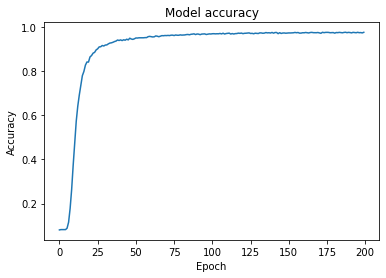

In [13]:
import matplotlib.pyplot as plt
#plot how the accuracy changes as the model was trained
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Make Predictions and Create the Output .csv

From here it's fairly straightforward: Import the test data, convert it to a usable form using the same process as before, run predictions and export those predictions to a .csv file for submission. 

\#TODO:
Outputting the data is a more complex task than I originally considered due to needing to convert back to the original labels, and I'm certain there is a more effecient way to do it. 

In [14]:
import os
test_data = os.listdir(test_path)
len(test_data)

15610

In [15]:
test_data = pd.DataFrame(test_data, columns=['Image'])

In [16]:
X_test = prepare_image_data(test_data, test_path, test_data.shape[0])
clear_output()

In [17]:
predictions  = model.predict(X_test)

In [18]:
copy_pred = np.copy(predictions)
idx = np.argmax(copy_pred, axis=1)
copy_pred[:,idx] = 0
idx2 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx2] = 0
idx3 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx3] = 0
idx4 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx4] = 0
idx5 = np.argmax(copy_pred, axis=1)

In [19]:
from numpy import argmax

results = []

threshold = 0.05 #threshold - only consider answers with a probability higher than it
for i in range(0, predictions.shape[0]):
#for i in range(0, 10):
    each = np.zeros((4251, 1))
    each2 = np.zeros((4251, 1))
    each3 = np.zeros((4251, 1))
    each4 = np.zeros((4251, 1))
    each5 = np.zeros((4251, 1))
    if((predictions[i, idx5[i]] > threshold)):
        each5[idx5[i]] = 1
        each4[idx4[i]] = 1
        each3[idx3[i]] = 1
        each2[idx2[i]] = 1
        each[idx[i]] = 1
        tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0], label_encoder.inverse_transform([argmax(each4)])[0], label_encoder.inverse_transform([argmax(each5)])[0]]
    else:
        if((predictions[i, idx4[i]] > threshold)):
            print(predictions[i, idx4[i]])
            each4[idx4[i]] = 1
            each3[idx3[i]] = 1
            each2[idx2[i]] = 1
            each[idx[i]] = 1
            tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0], label_encoder.inverse_transform([argmax(each4)])[0]]
        else:
            if((predictions[i, idx3[i]] > threshold)):
                each3[idx3[i]] = 1
                each2[idx2[i]] = 1
                each[idx[i]] = 1
                tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0]]
            else:
                if((predictions[i, idx2[i]] > threshold)):
                    each2[idx2[i]] = 1
                    each[idx[i]] = 1
                    tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0]]
                else:
                    each[idx[i]] = 1
                    tags = label_encoder.inverse_transform([argmax(each)])[0]
    results.append(tags)

In [20]:
import csv

myfile = open('output.csv','w')

column= ['Image', 'Id']

wrtr = csv.writer(myfile, delimiter=',')
wrtr.writerow(column)

for i in range(0, test_data.shape[0]):
    pred = ""
    if(len(results[i])==5):
        if (results[i][4]!=results[i][0]):
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3] + " " + results[i][4]
        else:
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3]
    else:
        if(len(results[i])==4):
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3]
        else:
            if(len(results[i])==3):
                pred = results[i][0] + " " + results[i][1] + " " + results[i][2]
            else:
                if(len(results[i])==2):
                    pred = results[i][0] + " " + results[i][1]
                else:
                    pred = results[i]
            
    result = [test_data['Image'][i], pred]
    #print(result)
    wrtr.writerow(result)
    
myfile.close()